# Flight Price Prediction
---

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency 
from sklearn import preprocessing 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Importing dataset

1. Since data is in form of excel file we have to use pandas read_excel to load the data
2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3. Check whether any null values are there or not. if it is present then following can be done,
    1. Imputing data using Imputation method in sklearn
    2. Filling NaN values with mean, median and mode using fillna() method
4. Describe data --> which can give statistical analysis

In [6]:
train=pd.read_excel("Data_Train.xlsx")

In [7]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [8]:
print(train.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [9]:
train=train.dropna()

# EDA

In [10]:
train=train.drop_duplicates()

From description we can see that Date_of_Journey is a object data type,\
Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas **to_datetime** to convert object data type to datetime dtype.

<span style="color: red;">**.dt.day method will extract only day of that date**</span>\
<span style="color: red;">**.dt.month method will extract only month of that date**</span>

In [11]:
train['Journey_Day'] = pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.day
train['Journey_Month'] = pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.month
train['weekday']= pd.to_datetime(train.Date_of_Journey, format='%d/%m/%Y').dt.weekday

In [12]:
#Transforming duration to minutes
def duration(test):
    test = test.strip()
    total=test.split(' ')
    to=total[0]
    hrs=(int)(to[:-1])*60
    if((len(total))==2):
        mint=(int)(total[1][:-1])
        hrs=hrs+mint
    test=str(hrs)
    return test
train['Duration']=train['Duration'].apply(duration)

In [13]:
#Categorising departure and arrival time
def deparrtime(x):
    x=x.strip()
    tt=(int)(x.split(':')[0])
    if(tt>=16 and tt<21):
        x='Evening'
    elif(tt>=21 or tt<5):
        x='Night'
    elif(tt>=5 and tt<11):
        x='Morning'
    elif(tt>=11 and tt<16):
        x='Afternoon'
    return x
train['Dep_Time']=train['Dep_Time'].apply(deparrtime)
train['Arrival_Time']=train['Arrival_Time'].apply(deparrtime)

In [14]:
#Refining total stops column
def stops(x):
    if(x=='non-stop'):
        x=str(0)
    else:
        x.strip()
        stps=x.split(' ')[0]
        x=stps
    return x
train['Total_Stops']=train['Total_Stops'].apply(stops)

In [15]:
train=train.drop(["Date_of_Journey","Route"],axis=1) #Date of journey, Route dropped because they dont add value to the prediction much

In [16]:
train.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday
0,IndiGo,Banglore,New Delhi,Night,Night,170,0,No info,3897,24,3,6
1,Air India,Kolkata,Banglore,Morning,Afternoon,445,2,No info,7662,1,5,2
2,Jet Airways,Delhi,Cochin,Morning,Night,1140,2,No info,13882,9,6,6
3,IndiGo,Kolkata,Banglore,Evening,Night,325,1,No info,6218,12,5,6
4,IndiGo,Banglore,New Delhi,Evening,Night,285,1,No info,13302,1,3,4


In [18]:
#Grouping classes with very low frequency with Airline
for i in range(0,len(train["Airline"])):
    if train["Airline"].iloc[i]=="Multiple carriers Premium economy":
         train["Airline"].iloc[i]="Others"
    elif train["Airline"].iloc[i]=="Vistara Premium economy":
         train["Airline"].iloc[i]="Others"
    elif train["Airline"].iloc[i]=="Trujet":
         train["Airline"].iloc[i]="Others"

C:\Users\mansnothot\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
for col in train.columns:
    if train[col].dtype=="object":
        print(train[col].value_counts())
        print()

Jet Airways             3700
IndiGo                  2043
Air India               1694
Multiple carriers       1196
SpiceJet                 815
Vistara                  478
Air Asia                 319
GoAir                    194
Others                    17
Jet Airways Business       6
Name: Airline, dtype: int64

Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: Source, dtype: int64

Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

Morning      4227
Evening      2784
Afternoon    1992
Night        1459
Name: Dep_Time, dtype: int64

Night        3562
Evening      3001
Morning      1962
Afternoon    1937
Name: Arrival_Time, dtype: int64

170     544
90      386
165     335
175     332
155     329
       ... 
205       1
1910      1
2345      1
1650      1
1940      1
Name: Duration, Length: 367, dtype: int64

1    5625
0    3475
2    1318
3      43
4   

In [20]:
#Refining No info class in Additional info
for i in range(train.shape[0]):
    if(train['Additional_Info'].iloc[i]=='No info'):
        train['Additional_Info'].iloc[i]='No Info'

In [21]:
#Grouping classes with very low frequency with Additional_Info
for i in range(0,len(train["Additional_Info"])):
    if train["Additional_Info"].iloc[i]== 'No check-in baggage included':
         train["Additional_Info"].iloc[i]="Others"
    elif train["Additional_Info"].iloc[i]=='1 Long layover':
         train["Additional_Info"].iloc[i]="Others"
    elif train["Additional_Info"].iloc[i]== 'Change airports':
         train["Additional_Info"].iloc[i]="Others"
    elif train["Additional_Info"].iloc[i]=='Red-eye flight':
         train["Additional_Info"].iloc[i]="Others"

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Dep_Time         10462 non-null  object
 4   Arrival_Time     10462 non-null  object
 5   Duration         10462 non-null  object
 6   Total_Stops      10462 non-null  object
 7   Additional_Info  10462 non-null  object
 8   Price            10462 non-null  int64 
 9   Journey_Day      10462 non-null  int64 
 10  Journey_Month    10462 non-null  int64 
 11  weekday          10462 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 1.0+ MB


In [23]:
train["Duration"]=train["Duration"].astype(int)
train["weekday"]=train["weekday"].astype(object)
train["Journey_Day"]=train["Journey_Day"].astype(object)
train["Journey_Month"]=train["Journey_Month"].astype(object)

# Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are,
1. <span style="color: blue;">**Nominal data**</span> --> data are not in any order --> <span style="color: green;">**OneHotEncoder**</span> is used in this case
2. <span style="color: blue;">**Ordinal data**</span> --> data are in order --> <span style="color: green;">**LabelEncoder**</span> is used in this case

In [25]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = train[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Others,Airline_SpiceJet,Airline_Vistara
0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


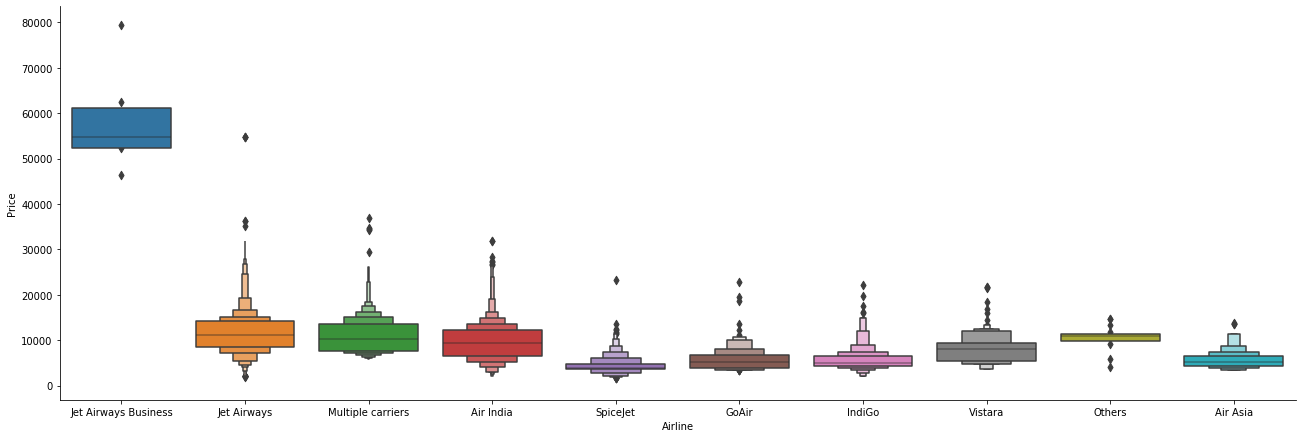

In [28]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

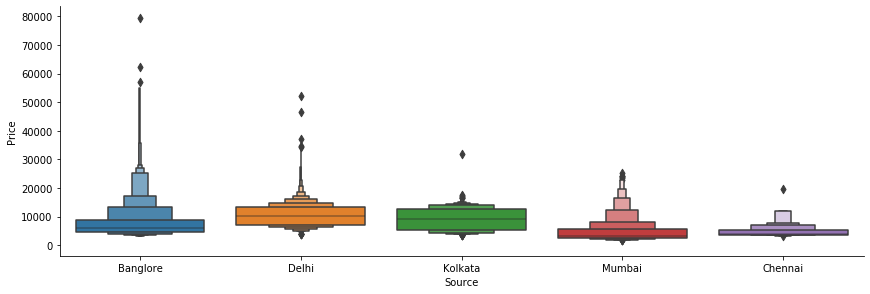

In [27]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [30]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = train[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [31]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = train[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [33]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
train = pd.concat([train, Airline, Source, Destination], axis = 1)

In [35]:
train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [36]:
train

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday,Airline_Air India,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,Night,Night,170,0,No Info,3897,24,3,6,0,...,0,0,0,0,0,0,0,0,0,1
1,Morning,Afternoon,445,2,No Info,7662,1,5,2,1,...,0,0,0,1,0,0,0,0,0,0
2,Morning,Night,1140,2,No Info,13882,9,6,6,0,...,0,0,1,0,0,1,0,0,0,0
3,Evening,Night,325,1,No Info,6218,12,5,6,0,...,0,0,0,1,0,0,0,0,0,0
4,Evening,Night,285,1,No Info,13302,1,3,4,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Evening,Night,150,0,No Info,4107,9,4,1,0,...,0,0,0,1,0,0,0,0,0,0
10679,Evening,Night,155,0,No Info,4145,27,4,5,1,...,0,0,0,1,0,0,0,0,0,0
10680,Morning,Afternoon,180,0,No Info,7229,27,4,5,0,...,0,0,0,0,0,0,1,0,0,0
10681,Afternoon,Afternoon,160,0,No Info,12648,1,3,4,0,...,1,0,0,0,0,0,0,0,0,1


In [37]:
# Import label encoder 
colnames = list(train.columns)
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for col in colnames:
    if train[col].dtype==object:
        train[col]= label_encoder.fit_transform(train[col])
        train[col]=train[col].astype(object)

### Outliers treatment

In [38]:
cnames =  ["Price"]
#delete outliers from data
for i in cnames:
    q75, q25 = np.percentile(train.loc[:,i], [75 ,25])
    iqr = q75 - q25
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    train = train.drop(train[train.loc[:,i] < min].index)
    train = train.drop(train[train.loc[:,i] > max].index)

In [39]:
train["Duration"]= (train["Duration"] - train["Duration"].mean())/train["Duration"].std()

# Test data Preprocessing

In [40]:
#Doing similar pre-processing in test data

In [96]:
test=pd.read_excel("Test_set.xlsx")

In [97]:
test['Journey_Day'] = pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.day
test['Journey_Month'] = pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.month
test['weekday']= pd.to_datetime(test.Date_of_Journey, format='%d/%m/%Y').dt.weekday

In [98]:
test['Duration']=test['Duration'].apply(duration)

In [99]:
test['Dep_Time']=test['Dep_Time'].apply(deparrtime)
test['Arrival_Time']=test['Arrival_Time'].apply(deparrtime)

In [100]:
test['Total_Stops']=test['Total_Stops'].apply(stops)

In [101]:
test=test.drop(["Date_of_Journey","Route"],axis=1)

In [102]:
for i in range(0,len(test["Airline"])):
    if test["Airline"].iloc[i]=="Multiple carriers Premium economy":
         test["Airline"].iloc[i]="Others"
    elif test["Airline"].iloc[i]=="Vistara Premium economy":
         test["Airline"].iloc[i]="Others"
    elif test["Airline"].iloc[i]=="Trujet":
         test["Airline"].iloc[i]="Others"
    elif test["Airline"].iloc[i]=="Jet Airways Business":
         test["Airline"].iloc[i]="Others"

C:\Users\mansnothot\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [103]:
for i in range(0,len(test["Additional_Info"])):
    if test["Additional_Info"].iloc[i]== 'No check-in baggage included':
         test["Additional_Info"].iloc[i]="Others"
    elif test["Additional_Info"].iloc[i]=='1 Long layover':
         test["Additional_Info"].iloc[i]="Others"
    elif test["Additional_Info"].iloc[i]== 'Change airports':
         test["Additional_Info"].iloc[i]="Others"
    elif test["Additional_Info"].iloc[i]=='Business class':
         test["Additional_Info"].iloc[i]="Others"

In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Source           2671 non-null   object
 2   Destination      2671 non-null   object
 3   Dep_Time         2671 non-null   object
 4   Arrival_Time     2671 non-null   object
 5   Duration         2671 non-null   object
 6   Total_Stops      2671 non-null   object
 7   Additional_Info  2671 non-null   object
 8   Journey_Day      2671 non-null   int64 
 9   Journey_Month    2671 non-null   int64 
 10  weekday          2671 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 229.7+ KB


In [105]:
test["Duration"]=test["Duration"].astype(int)
test["weekday"]=test["weekday"].astype(object)
test["Journey_Day"]=test["Journey_Day"].astype(object)
test["Journey_Month"]=test["Journey_Month"].astype(object)

In [106]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = test[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Others,Airline_SpiceJet,Airline_Vistara
0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0


In [107]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = test[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [108]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = test[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,0,0,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [109]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

test = pd.concat([test, Airline, Source, Destination], axis = 1)

In [110]:
test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [111]:
# Import label encoder 
colnames = list(test.columns)
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for col in colnames:
    if test[col].dtype==object:
        test[col]= label_encoder.fit_transform(test[col])
        test[col]=test[col].astype(object)

In [112]:
test["Duration"]= (test["Duration"] - test["Duration"].mean())/test["Duration"].std()

In [113]:
test

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_Day,Journey_Month,weekday,Airline_Air India,Airline_GoAir,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,3,0.030170,1,1,2,3,3,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2,2,-0.796392,1,1,4,2,6,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1.563791,1,0,7,2,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,2,3,0.279135,1,1,7,2,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,3,3,-0.935812,0,1,8,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,1,1.583708,1,1,2,3,3,1,0,...,0,0,0,1,0,0,0,0,0,0
2667,0,1,-0.965688,0,1,9,0,2,0,0,...,0,0,0,1,0,0,0,0,0,0
2668,3,3,-0.487676,1,1,2,0,2,0,0,...,0,0,1,0,0,1,0,0,0,0
2669,3,1,0.548016,1,1,2,0,2,1,0,...,0,0,1,0,0,1,0,0,0,0


In [116]:
train.columns,test.columns

(Index(['Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
        'Additional_Info', 'Price', 'Journey_Day', 'Journey_Month', 'weekday',
        'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
        'Airline_Jet Airways', 'Airline_Jet Airways Business',
        'Airline_Multiple carriers', 'Airline_Others', 'Airline_SpiceJet',
        'Airline_Vistara', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
        'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi',
        'Destination_Hyderabad', 'Destination_Kolkata',
        'Destination_New Delhi'],
       dtype='object'),
 Index(['Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
        'Additional_Info', 'Journey_Day', 'Journey_Month', 'weekday',
        'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
        'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_Others',
        'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi',
        'Source_Kolkata', 'Source_Mumba

In [114]:
train

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,weekday,Airline_Air India,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,3,3,-0.915020,0,4,3897,8,0,6,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,-0.366204,2,4,7662,0,2,2,1,...,0,0,0,1,0,0,0,0,0,0
2,2,3,1.020802,2,4,13882,3,3,6,0,...,0,0,1,0,0,1,0,0,0,0
3,1,3,-0.605687,1,4,6218,4,2,6,0,...,0,0,0,1,0,0,0,0,0,0
4,1,3,-0.685515,1,4,13302,0,0,4,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,1,3,-0.954933,0,4,4107,3,1,1,0,...,0,0,0,1,0,0,0,0,0,0
10679,1,3,-0.944955,0,4,4145,9,1,5,1,...,0,0,0,1,0,0,0,0,0,0
10680,2,0,-0.895063,0,4,7229,9,1,5,0,...,0,0,0,0,0,0,1,0,0,0
10681,0,0,-0.934977,0,4,12648,0,0,4,0,...,1,0,0,0,0,0,0,0,0,1


In [117]:
# divide the df_train into iput and output
y=train["Price"]
df_x=train.drop(columns=["Price"])

In [118]:
y

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10368, dtype: int64

In [119]:
#let's bring the features to same scale
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(df_x)
x=sc.transform(df_x)
x=pd.DataFrame(x,columns=df_x.columns)

In [120]:
x

,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_Day,Journey_Month,weekday,Airline_Air India,Airline_GoAir,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1.582403,1.169409,-0.915064,-1.208232,0.348256,1.228022,-1.482816,1.527915,-0.439583,-0.138088,...,-0.219845,-0.195319,-0.846664,-0.617044,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,3.363560
1,0.533470,-1.494325,-0.366222,1.815046,0.348256,-1.569634,0.244678,-0.460902,2.274886,-0.138088,...,-0.219845,-0.195319,-0.846664,1.620630,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,-0.297304
2,0.533470,1.169409,1.020851,1.815046,0.348256,-0.520513,1.108426,1.527915,-0.439583,-0.138088,...,-0.219845,-0.195319,1.181106,-0.617044,-0.267427,1.181106,-0.372780,-0.267427,-0.195319,-0.297304
3,-0.515462,1.169409,-0.605717,0.303407,0.348256,-0.170806,0.244678,1.527915,-0.439583,-0.138088,...,-0.219845,-0.195319,-0.846664,1.620630,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,-0.297304
4,-0.515462,1.169409,-0.685548,0.303407,0.348256,-1.569634,-1.482816,0.533507,-0.439583,-0.138088,...,-0.219845,-0.195319,-0.846664,-0.617044,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,3.363560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10363,-0.515462,1.169409,-0.954980,-1.208232,0.348256,-0.520513,-0.619069,-0.958106,-0.439583,-0.138088,...,-0.219845,-0.195319,-0.846664,1.620630,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,-0.297304
10364,-0.515462,1.169409,-0.945001,-1.208232,0.348256,1.577729,-0.619069,1.030711,2.274886,-0.138088,...,-0.219845,-0.195319,-0.846664,1.620630,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,-0.297304
10365,0.533470,-1.494325,-0.895106,-1.208232,0.348256,1.577729,-0.619069,1.030711,-0.439583,-0.138088,...,-0.219845,-0.195319,-0.846664,-0.617044,-0.267427,-0.846664,2.682545,-0.267427,-0.195319,-0.297304
10366,-1.564394,-1.494325,-0.935022,-1.208232,0.348256,-1.569634,-1.482816,0.533507,-0.439583,-0.138088,...,4.548668,-0.195319,-0.846664,-0.617044,-0.267427,-0.846664,-0.372780,-0.267427,-0.195319,3.363560


->This method will take too long so i didnt run but it is best for small dataset

In [121]:
#!pip install -U scikit-learn

In [122]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [123]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 42,test_size=0.20)

In [124]:
#lets make a function which evaluates the model using cross_val_score
from sklearn.model_selection import cross_val_score
def model_evaluation(model,x,y):
    c_scores=cross_val_score(model,x,y,cv=5,scoring="r2")
    print("Mean r2 score for regressor: ",c_scores.mean())
    print("standard deviation in r2 score for regressor: ",c_scores.std())
    print(c_scores)

# Random Forest Hyperparameter Tuning
Choose following method for hyperparameter tuning
RandomizedSearchCV --> Fast
GridSearchCV
Assign hyperparameters in form of dictionery
Fit the model
Check best paramters and best score

In [125]:
#Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [126]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [127]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rfreg=RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rfreg, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [134]:
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [168]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [128]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 42,test_size=0.20)
rfreg=RandomForestRegressor(n_estimators=700,min_samples_split= 15,min_samples_leaf= 1,max_features='auto',max_depth=20)
rfreg.fit(x_train,y_train.values.ravel())
y_pred=rfreg.predict(x_test)
print("RMSE is: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("r2_score is: ",r2_score(y_test,y_pred))
#cross_val_score for Random Forest Regressor
print("Random Forest Regressor\n\n")
model_evaluation(rfreg,x,y)

RMSE is:  1357.4672255107137
Mean squared error: 1842717.27
Mean absolute error: 788.95
r2_score is:  0.8864799872759237
Random Forest Regressor


Mean r2 score for regressor:  0.8951920326628725
standard deviation in r2 score for regressor:  0.005041664718763905
[0.90146984 0.8971291  0.8932916  0.88654022 0.8975294 ]


<Figure size 576x576 with 0 Axes>

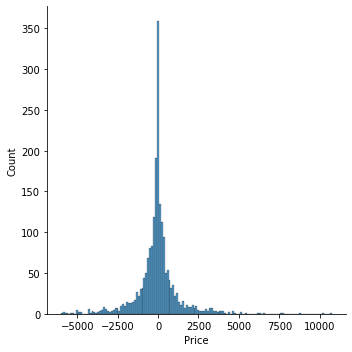

In [236]:
prediction = rfreg.predict(x_test)
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction)
plt.show()

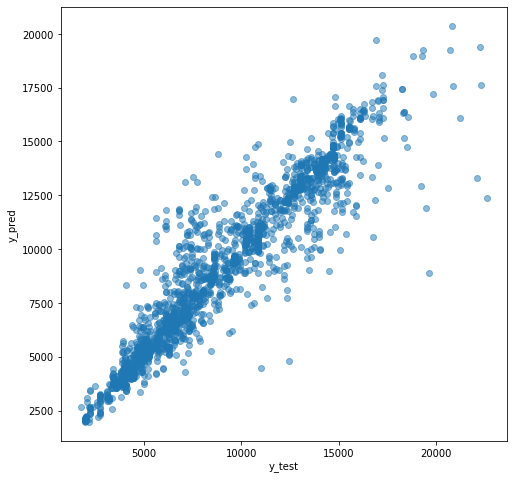

In [237]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# XGBoost hyper-parameter tuning

In [172]:
#XGBoost hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV
def xgbtuning(x, y):
    params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [3, 5, 7, 9],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'n_estimators' : [1000],
        'objective': ['reg:linear']
    }

    xgb_model = XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = params,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x,y)

    return gsearch.best_params_

In [173]:
xgbtuning(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


[21:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


{'subsample': 0.7,
 'objective': 'reg:linear',
 'n_estimators': 1000,
 'min_child_weight': 9,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [238]:
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 45,test_size=0.20)
xgb_model = XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.1,
 max_depth= 5,
 min_child_weight= 9,
 n_estimators= 1000,
 subsample= 0.7)
xgb_model.fit(x_train,y_train)
y_pred=xgb_model.predict(x_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("RMSE is: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2_score is: ",r2_score(y_test,y_pred) )
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("XG Boost Regressor\n\n")
model_evaluation(xgb_model,x,y)

RMSE is:  1263.5336689659582
r2_score is:  0.9085418591247201
Mean squared error: 1596517.33
Mean absolute error: 803.65
XG Boost Regressor


Mean r2 score for regressor:  0.9121871366669716
standard deviation in r2 score for regressor:  0.003780970911898833
[0.91647818 0.90941053 0.91706687 0.90824787 0.90973224]


<Figure size 576x576 with 0 Axes>

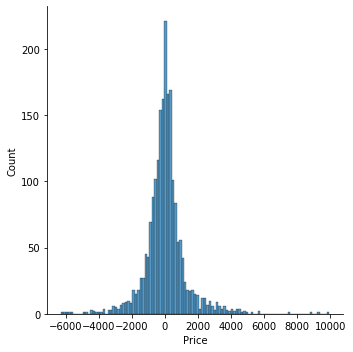

In [239]:
prediction = xgb_model.predict(x_test)
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction)
plt.show()

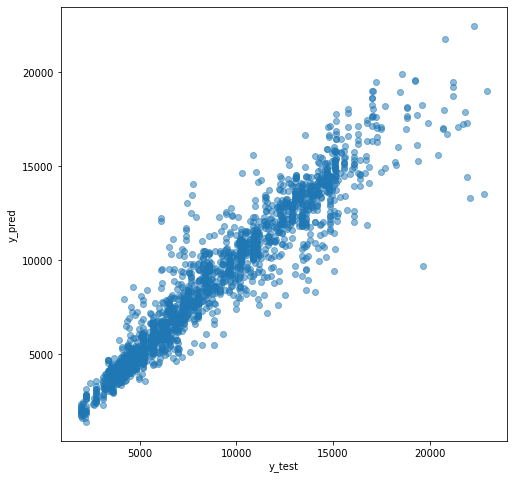

In [240]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [176]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

# Gradient Boost hyper-parameter tuning

In [94]:
#GBoost hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV
def gbtuning(x, y):

    params = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[1000]
    }

    gbm = GradientBoostingRegressor()


    gsearch = RandomizedSearchCV(estimator = gbm,
                           param_distributions = params,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x,y)

    return gsearch.best_params_

In [95]:
gbtuning(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 43.4min finished
C:\Users\mansnothot\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'subsample': 0.5,
 'n_estimators': 1000,
 'min_samples_split': 0.13636363636363638,
 'min_samples_leaf': 0.1,
 'max_features': 'log2',
 'max_depth': 3,
 'learning_rate': 0.01,
 'criterion': 'mae'}

RMSE is:  2524.883661696244
r2_score is:  0.6026393922737499
Mean squared error: 6375037.51
Mean absolute error: 1867.19
Gradient Boost Regressor




C:\Users\mansnothot\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


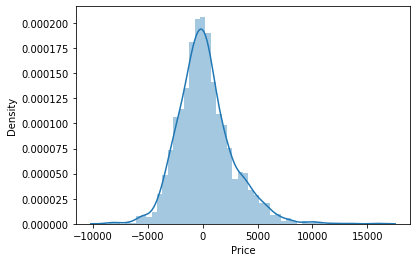

In [225]:
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 41,test_size=0.20)
gbm = GradientBoostingRegressor(subsample= 0.5,n_estimators= 1000,min_samples_split= 0.13636363636363638,
min_samples_leaf= 0.1,
max_features = 'log2',
max_depth= 3,
learning_rate=0.01,
criterion = 'mae')
gbm.fit(x_train,y_train.values.ravel())
y_pred=gbm.predict(x_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("RMSE is: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2_score is: ",r2_score(y_test,y_pred) )
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("Gradient Boost Regressor\n\n")
sns.distplot(y_test-y_pred)
plt.show()

<Figure size 576x576 with 0 Axes>

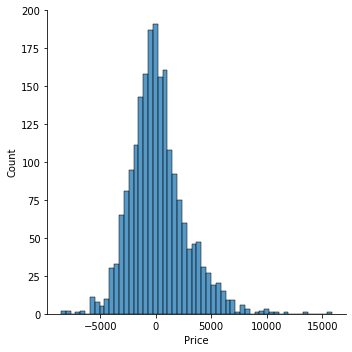

In [233]:
prediction = gbm.predict(x_test)
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction)
plt.show()

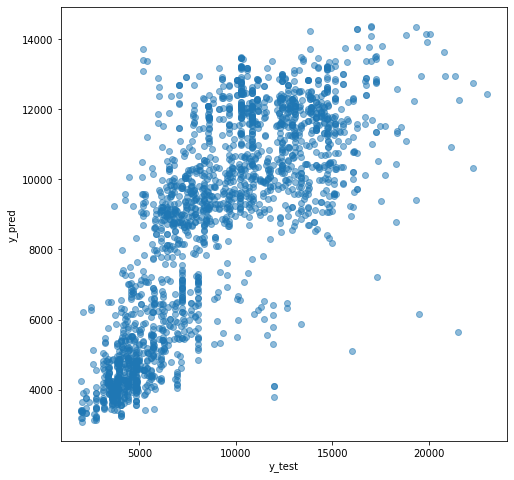

In [234]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Lets save the model

In [129]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf_finalmmmmmm.pkl', 'wb')

# dump information to that file
pickle.dump(rfreg, file)

In [131]:
model = open('flight_rf_finalmmmmmm.pkl','rb')
forest = pickle.load(model)

In [132]:
y_prediction = forest.predict(x_test)

In [133]:
from sklearn import metrics
metrics.r2_score(y_test, y_prediction)

0.8864799872759237

### For xgboost

In [217]:
#Lets also save model
import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(xgb_model,'flight_xg.pkl')

['flight_xg.pkl']

In [218]:
model = open('flight_xg.pkl','rb')
boost = pickle.load(model)

In [219]:
y_prediction = boost.predict(x_test)

In [220]:
metrics.r2_score(y_test, y_prediction)

0.9038665273685295

I think i will go with Random forest  i dont know for some reason xg boost model size is low as 3mb ,
the random forest model size is 54mb 